In [ ]:
import os
import time
import tracemalloc
import matplotlib.pyplot as plt
import pandas as pd

from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms as crypto_algorithms, modes
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.decrepit.ciphers.algorithms import TripleDES

Entradas (texto pequeno, texto grande, imagem)

In [ ]:
custom_inputs = {
    "Texto curto": b"senha123",
    "Texto longo": b"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.",
    "Imagem": None,
    "Texto Criptografado": b"7f08223fac21ac82eb20b47afe30709aea90f669a3225a4a207a962b420a0d4fd9ae7b2754194b4697814a1b76e8b2c6d9f705271950990af49adf04de2a3462dc03bd4f54d85b6e18cf7f6333150fcdaa1033c4e9d334892be95be0d1eaf32a15bf36f7bee2078454f57585df54782484ba47aad15113ee50351514677f75737148ffdc17c62dacfddb92c0b5bc8de34d9ee01d7f059c4397588344316628aec6f57ba5f40809bd886b4110a5125051cc204aaeafaf8127500657808ceadcc5583b5bae354a11a47f8498883c200f3896609371aa00803e1ee95508302a84e50f1a3f8ea158e680cf7801ab4746139ef51541dbfacbf24ff7f27c734ccc07620f6da3e450a1157297e62282548204b6a7e5132193d2e841f63c7f3f0e48aa0a7a4b7dcc45891e5e2fc2e1a39b276abd0259874bc1c5f4971dc3aa89dd10ff2406ee63a06696ad0fdd5ef22b9ae66efa2b9e05445b7531731305de1f9d2be6d7b53f8d94a55ce87d073c6cb81893eb763c84bed170cb37880f9e7b757720ccb092190a5301b04d3c980375d873472900db456dd7d103040d827d7f29dac4a761b7a8a29ea0702a597c59a7170d66e205d4981d7c16f609cb1bff3e0acf7e4c1a",
    "PDF": None,
    "JSON": None,
    "CSV": None,
}

pdf_path = "/content/teste_pdf.pdf"
if(os.path.exists(pdf_path)):
    with open(pdf_path, "rb") as f:
        custom_inputs["PDF"] = f.read()
else:
    custom_inputs.pop("PDF")

json_path = "/content/teste_json.json"
if os.path.exists(json_path):
    with open(json_path, "rb") as f:
        custom_inputs["JSON"] = f.read()
else:
    custom_inputs.pop("JSON")

csv_path = "/content/teste_csv.csv"
if os.path.exists(csv_path):
    with open(csv_path, "rb") as f:
        custom_inputs["CSV"] = f.read()
else:
    custom_inputs.pop("CSV")

file_path = "/content/teste_imagem.jpg"
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        custom_inputs["Imagem"] = f.read()
else:
    custom_inputs.pop("Imagem")


Algoritmos (AES, RSA, 3DES)

In [ ]:
def encrypt_des(data):
    key = os.urandom(8)
    iv = os.urandom(8)
    cipher = Cipher(crypto_algorithms.TripleDES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    pad_len = 8 - len(data) % 8
    padded_data = data + bytes([pad_len] * pad_len)
    return encryptor.update(padded_data) + encryptor.finalize()

def encrypt_aes(data):
    key = os.urandom(32)
    iv = os.urandom(16)
    cipher = Cipher(crypto_algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    pad_len = 16 - len(data) % 16
    padded_data = data + bytes([pad_len] * pad_len)
    return encryptor.update(padded_data) + encryptor.finalize()

def encrypt_rsa(data):
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048, backend=default_backend())
    public_key = private_key.public_key()
    return public_key.encrypt(
        data[:190],
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )

algorithms_map = {
    "AES": encrypt_aes,
    "RSA": encrypt_rsa,
    "3DES": encrypt_des
}

Cálculo das Métricas de Desempenho

In [ ]:
import math

def calculate_entropy(data_bytes):
    if not data_bytes:
        return 0
    freq = {}
    for b in data_bytes:
        freq[b] = freq.get(b, 0) + 1
    entropy = 0
    length = len(data_bytes)
    for count in freq.values():
        p = count / length
        entropy -= p * math.log2(p)
    return entropy

def measure_performance_tracemalloc(func, *args):
    tracemalloc.start()
    start_time = time.perf_counter()
    output = func(*args)
    end_time = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    input_size_kb = len(args[0]) / 1024  # supõe que o dado está em args[0]
    elapsed_time = end_time - start_time
    throughput = input_size_kb / elapsed_time if elapsed_time > 0 else 0  # KB/s

    entropy = calculate_entropy(output) if isinstance(output, bytes) else None
    output_size_kb = len(output) / 1024 if isinstance(output, (bytes, bytearray)) else None

    return {
        "time_sec": elapsed_time,
        "memory_kb": peak / 1024,
        "throughput_kb_s": throughput,
        "output_size_kb": output_size_kb,
        "entropy": entropy,
        "output": output
    }


Testes

In [ ]:
results = []
for input_name, input_data in custom_inputs.items():
    for alg_name, alg_func in algorithms_map.items():
        if input_data is None:
            results.append({
                "Entrada": input_name,
                "Algoritmo": alg_name,
                "Tamanho_KB": None,
                "Tempo (s)": None,
                "Memória (KB)": None,
                "Throughput (KB/s)": None,
                "Tamanho Saída (KB)": None,
                "Entropia": None,
                "Saída Criptografada": "Dados de entrada ausentes"
            })
            continue

        if alg_name == "RSA" and len(input_data) > 190:
            results.append({
                "Entrada": input_name,
                "Algoritmo": alg_name,
                "Tamanho_KB": len(input_data) / 1024,
                "Tempo (s)": None,
                "Memória (KB)": None,
                "Throughput (KB/s)": None,
                "Tamanho Saída (KB)": None,
                "Entropia": None,
                "Saída Criptografada": "Muito grande para RSA"
            })
            continue

        perf = measure_performance_tracemalloc(alg_func, input_data)

        results.append({
            "Entrada": input_name,
            "Algoritmo": alg_name,
            "Tamanho_KB": len(input_data) / 1024,
            "Tempo (s)": perf["time_sec"],
            "Memória (KB)": perf["memory_kb"],
            "Throughput (KB/s)": perf["throughput_kb_s"],
            "Tamanho Saída (KB)": perf["output_size_kb"],
            "Entropia": perf["entropy"],
            "Saída Criptografada": perf["output"].hex() if isinstance(perf["output"], bytes) else str(perf["output"])
        })

results

/tmp/ipython-input-3-664957497.py:4: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  cipher = Cipher(crypto_algorithms.TripleDES(key), modes.CBC(iv), backend=default_backend())


[{'Entrada': 'Texto curto',
  'Algoritmo': 'AES',
  'Tamanho_KB': 0.0078125,
  'Tempo (s)': 0.03618466799998998,
  'Memória (KB)': 444.98046875,
  'Throughput (KB/s)': 0.21590636122465356,
  'Tamanho Saída (KB)': 0.015625,
  'Entropia': 3.75,
  'Saída Criptografada': '271c904928bdb34980a43e7e931c1e4e'},
 {'Entrada': 'Texto curto',
  'Algoritmo': 'RSA',
  'Tamanho_KB': 0.0078125,
  'Tempo (s)': 0.05477786800000217,
  'Memória (KB)': 3.130859375,
  'Throughput (KB/s)': 0.14262146894800087,
  'Tamanho Saída (KB)': 0.25,
  'Entropia': 7.155944531114784,
  'Saída Criptografada': '2928f575de7276642cf6f00cad1be87e971997aedf9503764266d66b7d45c2a3ae1084c683c4206e758224082180238cce4ecb34fa73fcb7254e3e31fef64a0b23d7374fe6eb82d57b886976189ae281c82d8c9537e40d748925bbaa78a872671acdc3153bedbdfc58b9749278e0132aad76c72806d4b7fd4baa379708ec73cd1c05c208e9a8c83e7f7f6c5a49c6bf30360e4b8049f9fcfc4f75505784bc9f281a3096ffcc4146a68985ccd2dfa20dca7159f692d849adac825bc6f7e848d13a354bab2c9b12f9367210011c283442ee3d

Gráficos

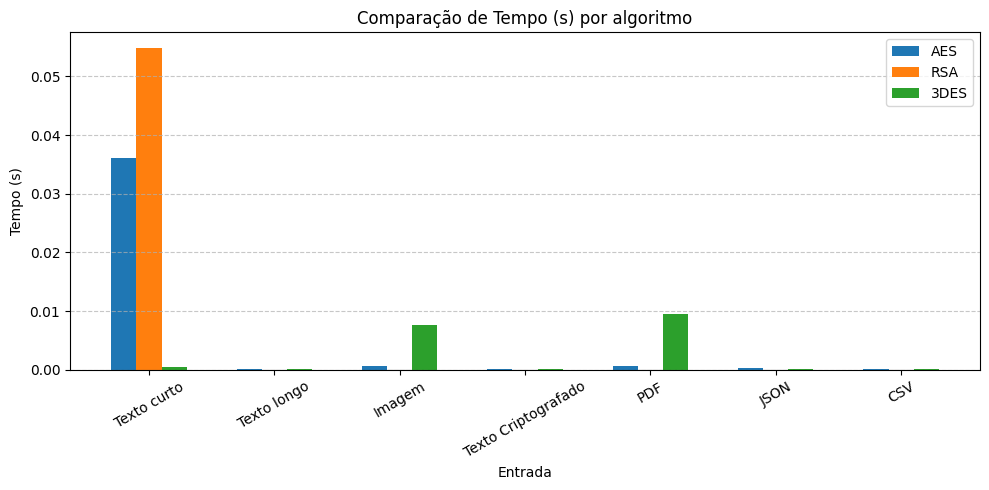

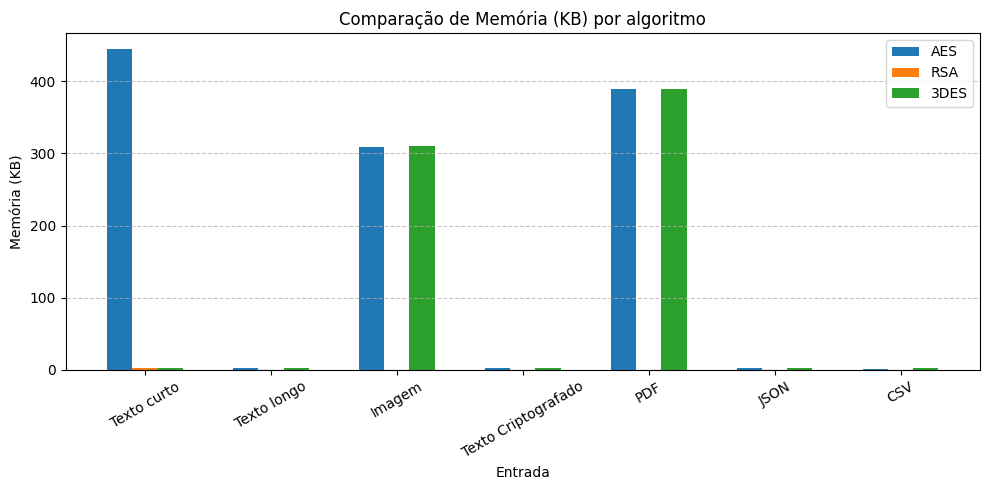

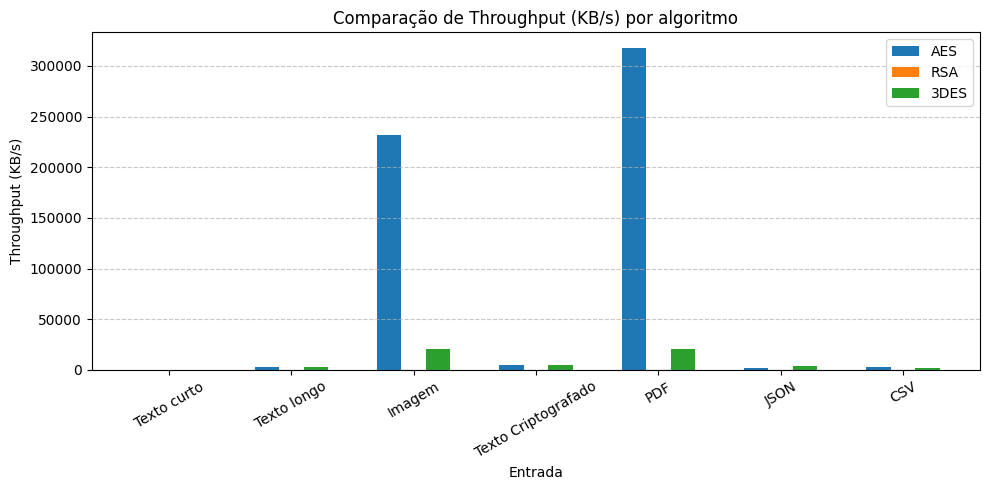

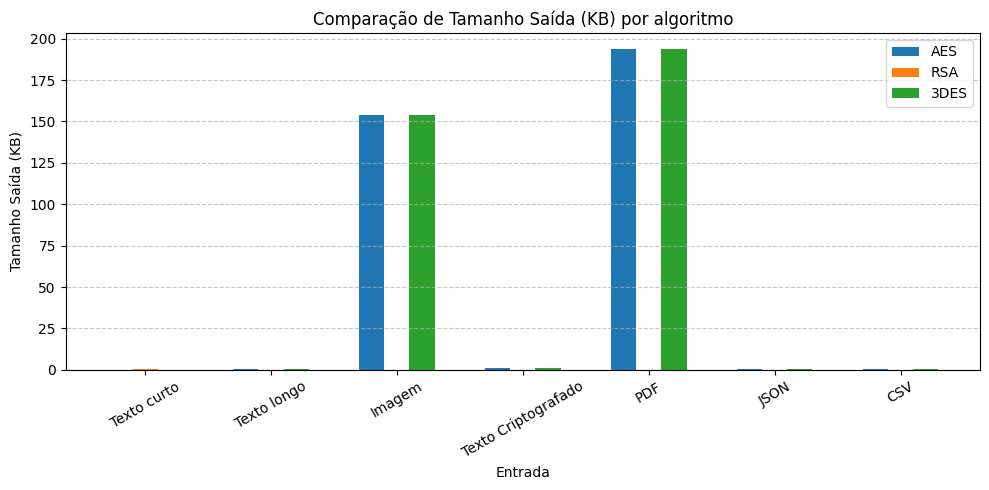

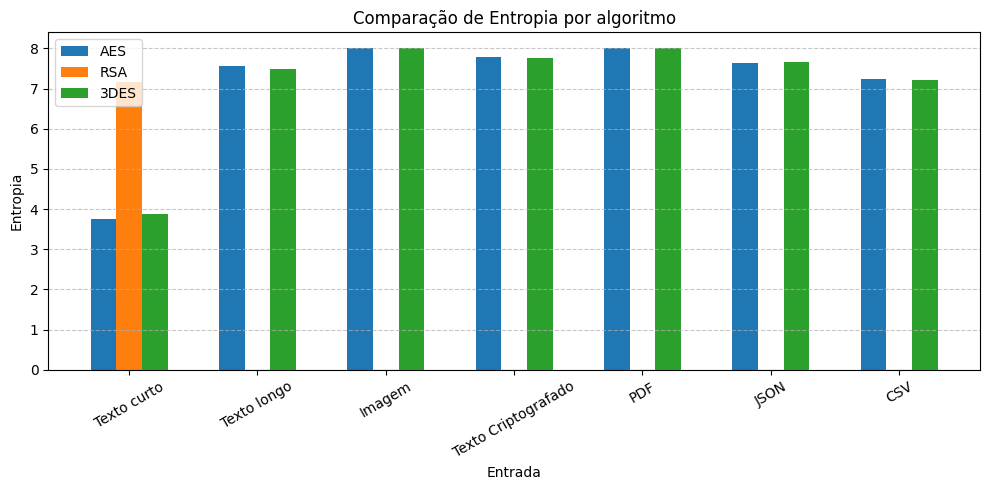

                Entrada Algoritmo  Tamanho_KB  Tempo (s)  Memória (KB)  \
20                  CSV      3DES    0.262695   0.000122      1.903320   
18                  CSV       AES    0.262695   0.000089      1.660156   
19                  CSV       RSA    0.262695        NaN           NaN   
8                Imagem      3DES  154.134766   0.007605    309.762695   
6                Imagem       AES  154.134766   0.000665    309.519531   
7                Imagem       RSA  154.134766        NaN           NaN   
17                 JSON      3DES    0.571289   0.000150      2.567383   
15                 JSON       AES    0.571289   0.000248      2.324219   
16                 JSON       RSA    0.571289        NaN           NaN   
14                  PDF      3DES  193.847656   0.009498    389.153320   
12                  PDF       AES  193.847656   0.000611    388.863281   
13                  PDF       RSA  193.847656        NaN           NaN   
11  Texto Criptografado      3DES    0

In [ ]:

df = pd.DataFrame(results)

def plot_metric_bar(metric):
    plt.figure(figsize=(10, 5))
    algs = df['Algoritmo'].unique()
    entradas = df['Entrada'].unique()
    x = range(len(entradas))
    width = 0.2

    for i, alg in enumerate(algs):
        subset = df[df['Algoritmo'] == alg]
        heights = []
        hatch_patterns = []

        for entrada in entradas:
            valor = subset[subset['Entrada'] == entrada][metric].values
            if len(valor) == 0 or pd.isna(valor[0]):
                heights.append(0)
                hatch_patterns.append('//')
            else:
                heights.append(valor[0])
                hatch_patterns.append(None)

        bar_x = [pos + i * width for pos in x]
        bars = plt.bar(bar_x, heights, width=width, label=alg)

        for bar, hatch in zip(bars, hatch_patterns):
            if hatch:
                bar.set_hatch(hatch)
                bar.set_color('lightgray')

    plt.title(f"Comparação de {metric} por algoritmo")
    plt.xlabel("Entrada")
    plt.ylabel(metric)
    plt.xticks([pos + width for pos in x], entradas, rotation=30)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_metric_bar("Tempo (s)")
plot_metric_bar("Memória (KB)")
plot_metric_bar("Throughput (KB/s)")
plot_metric_bar("Tamanho Saída (KB)")
plot_metric_bar("Entropia")


print(df.sort_values(by=["Entrada", "Algoritmo"]))

In [ ]:
#Salvar os dados em um arquivo csv
import pandas as pd
colunas_desejadas = ['Entrada', 'Algoritmo', 'Tempo (s)', 'Memória (KB)', 'Throughput (KB/s)', 'Entropia', 'Tamanho_KB']
df_filtrado = df[colunas_desejadas]
df_filtrado.to_csv('dados.csv', index=False)
